# MNIST Projet


In [118]:
#import des librairies

import matplotlib.pyplot as plt                           # Plotting
import numpy as np                                        # Numpy: Tableau Multidimensionnel
import pandas as pd                                       # Panda: Manipulation des Dataframe
import seaborn as sns                                     # Librairie de visualisation
import keras

# Librairies Scikit Learn pour la visualisation et le traitement des données
from sklearn.model_selection import train_test_split      # Split des jeux de données
from sklearn.metrics import confusion_matrix              # Analyse des performances de classification
from mlxtend.plotting import plot_confusion_matrix

import matplotlib.pyplot as plt                           # Plotting
import numpy as np                                        # Numpy: Tableau Multidimensionnel
import pandas as pd                                       # Panda: Manipulation des Dataframe
import seaborn as sns                                     # Librairie de visualisation

# Librairies Scikit Learn
from sklearn.model_selection import train_test_split      # Split des jeux de données
from sklearn.metrics import confusion_matrix              # Analyse des performances de classification
from mlxtend.plotting import plot_confusion_matrix

# Dataset des chiffres du MNIST
from keras.datasets import mnist

# Librairies Keras pour la construction du réseau CNN
from keras.models import Model, Sequential
from keras.models import load_model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import UpSampling2D, Dropout, Dense, Flatten

from tensorflow.keras.utils import plot_model              # Visualisation du modèle crée
from tensorflow.keras.callbacks import EarlyStopping       # Permet d'arrêter l'apprentissage quand il n'y a plus de progression
from keras.optimizers import Adam    

In [119]:
# fonction d'affichage pour développer les données matricielles 
def display_image(X, y, n, label=False):
    plt.figure(figsize=(20,2))
    for i in range(10):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(X.values[i].reshape(28,28))
        if label:
            plt.title("Digit: {}".format(y[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [120]:
#lecture des données
# données d'entrainement et données de test

train_dir = "./input/train.csv"
test_dir = "./input/test.csv"

In [121]:
# Lecture du jeu d'entrainement via pandas depuis un fichier csv
df_train = pd.read_csv(train_dir)

# Récupération des informations sur le Dataframe du jeu de données
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [122]:
df_train.head() #visualisation des premières lignes du dataframe

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* chaque pixel est codé de 0 à 255 -> 786 pixels pour une image de 28x28

* La première colonne représente le label appelé y (de 0 à 9) les autres colonnes les données des pixels

In [123]:
y_train = df_train["label"] #extrait uniquement la colonne label -> sortie cible du modèle (devient dataframe pandas contenant les classes à prédire)
X_train = df_train.drop(columns=["label"]) #toutes les colonnes sauf label -> données d'entrainement (devient dataframe pandas contenant les données d'entrainement)

y_train.head()



0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

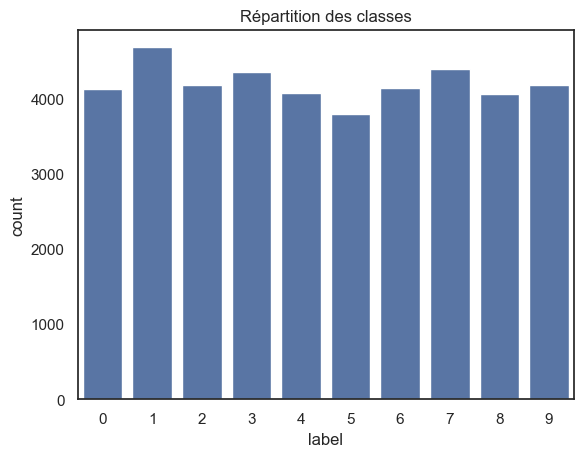

In [124]:
import seaborn as sns
# Visualisation de la répartition des labels
sns.set_theme(style='white', context='notebook', palette='deep')
ax = sns.countplot(x=y_train)
plt.title("Répartition des classes")
plt.show()

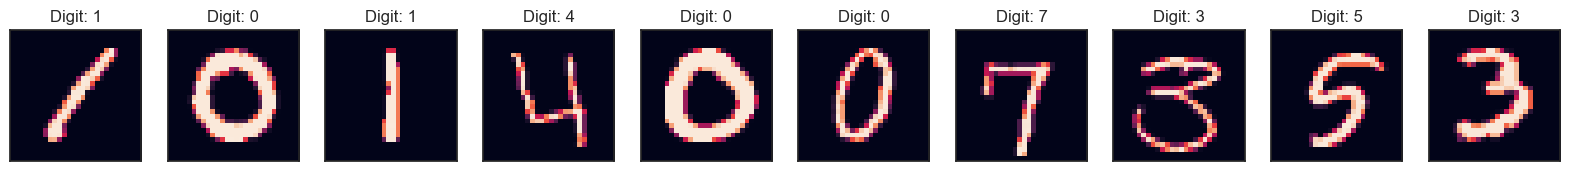

In [125]:
# On affiche 10 images connues avec leur labels
# X_train.values[0].reshape(28,28)
display_image(X_train, y_train, n=10, label=True)

# Préparation des données

#### 1. Séparation des données entre entrainement et test
utiliser la méthode train_test_split() de scikit_learn

#### 2. Reshape des données
remettre chaque exemple de 1D (784 valeurs) en structure spatiale 2D (28×28)
pour une bonne visualisation
pour faire des convolutions (car ça marche sur du 2D)

#### 3. Normalisation des valeurs
ramener toutes les valeurs entre [0, 1], en divisant chaque pixel par 255, 
pour pas qu'il y ait de poids bizarres pour les algos

#### 4. One hot encoding 
on fait une matrice de 10 colonnes pour les labels (pareil pour les poids, plus simple a traiter)
(label 4 : [0,0,0,0,1,0,0,0,0,0])

In [126]:
# 1. Split entre jeu d'entrainement et jeu de validation avec un ratio de 90/10
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [127]:
# 2. Reshape des data pour les formatter en 28x28x1 c'est à dire une matrice 3D
X_train = X_train.values.reshape(-1, 28,28,1)
X_val = X_val.values.reshape(-1, 28,28,1)

In [128]:
# Affichage de la nouvelle shape des données (maintenant sous forme de matrice 28x28)
X_train.shape

(37800, 28, 28, 1)

In [129]:
# Application d'un seuil pour contraster les images
def apply_contrast(X, seuil=150):
    X_contrast = X.copy()
    X_contrast[X_contrast >= seuil] = 255
    X_contrast[X_contrast < seuil] = 0
    return X_contrast

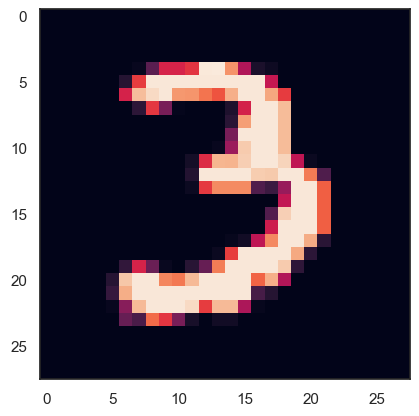

In [130]:
plt.imshow((X_train[9].squeeze()))

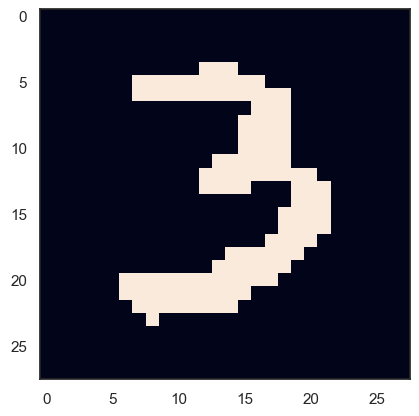

In [131]:
image = apply_contrast(X_train[9])
plt.imshow(image.squeeze())


In [132]:
# 3. Normalisation des données pour avoir des valeurs de pixels entre 0 et 255
# Nous n'avons pas besoin d'un Scaler car ici la normalisation est simple, donc on la fait à la main
X_train = X_train / 255.0
X_val = X_val / 255.0

In [133]:
# pd.get_dummies() possible aussi

from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(y_train, num_classes=10)
Y_val   = to_categorical(y_val, num_classes=10)

In [134]:
print("La valeur {} est encodée vers le vecteur {}".format(y_train[0], Y_train[0]))
print("valeur {} transformée en vecteur: {}".format(y_train[20], Y_train[20]))

La valeur 1 est encodée vers le vecteur [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
valeur 8 transformée en vecteur: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


### Augmentation des datas dispo en utilisant des transformations simples

In [135]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
          featurewise_center=False,            # set input mean to 0 over the dataset
          samplewise_center=False,             # set each sample mean to 0
          featurewise_std_normalization=False, # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,                 # apply ZCA whitening
          rotation_range=20,                   # randomly rotate images in the range 
          zoom_range = 0.1,                    # Randomly zoom image 
          width_shift_range=0.1,               # randomly shift images horizontally 
          height_shift_range=0.1,              # randomly shift images vertically 
          horizontal_flip=False,               # randomly flip images
          vertical_flip=False)                 # randomly flip images

### Création du modèle de Réseau de Convolution
Le processus de Convolution sous-entend généralement constitué de plusieurs étapes qui se répètent dans cet ordre :

    Couche de Convolution
    Max Pooling
    Regularization

La dernière couche est le classifier qui permet de donner la probabilité du résultat de classification de l'image (chien / chat). Dans notre cas, c'est la reconnaissance de 0 à 9. 

### Convolution 2D

Utilisation de filtre de convolution 2D pour récupérer des "features" dans les images (des lignes horizontales, verticales, diagonales ...) et si plusieurs couches de convolutions, on récupère des features plus complets (arrondis, quadrillage, ...)

Chaque filtre génère une feature map : une carte 2D indiquant où et à quel degré la feature a été détectée.

Plus le nombre de filtres est grand, plus le réseau peut détecter de motifs différents.
Première couche avec 16 filtres → on obtient 16 feature maps.

Chaque feature map peut être vue comme une “dimension” supplémentaire de l’image originale.

ATTENTION : si la première couche de Convolution comporte 16 filtres, alors l'image résiduels sera composée de 16 dimensions

### Max pooling 

Réduction de la taille des images (généralement par 2 en fonction des paramètre). 
Elles permettent d'extraires les caractéristiques les plus importantes et de briser la linéarité de l'image.


### Création du modèle de Convolution

réseau est basé sur plusieurs couche qui répètent le motif de Couche de Convolution , Normalisation , MaxPooling

In [136]:
# Initialisation 
model = Sequential()

# ------------------------------------
# Couche de Convolution et MaxPooling
# ------------------------------------

# Conv2D :

#     filters : nombres de filtres de convolutions
#     kernel_size : taille des filtres de la fenêtre de convolution 
#     input_shape : taille de l'image en entrée (à préciser seulement pour la première couche)
#     activation  : choix de la fonction d'activation

# BatchNormalisation : permet de normaliser les coefficients d'activation afin de les maintenirs proche de 0 pour simplifier les calculs numériques

# MaxPooling : Opération de maxPooling sur des données spatiales (2D)

# Dropout : permet de désactiver aléatoirement une proportion de neurones (afin d'éviter l'overfitting sur le jeu d'entrainement)
model.add(Input(shape=(28,28,1)))  # couche d'entrée indiquant la taille des images 28x28x1

model.add(Conv2D(filters = 32, kernel_size = (5, 5), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (5, 5), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(strides=(2,2)))
model.add(Dropout(0.2))

## Classifier

couche de sortie de 10 neurones (vecteur de proba pour les nombres de 0 à 9)


Flatten → convertit l’information spatiale en vecteur global.

Dense(512) → espace riche pour apprendre combinaisons non linéaires de features locales ; large capacité.

Dropout → régularise ce grand espace.

Dense(128) → compression, extraire représentation plus compacte et plus adaptée à la décision finale.

Dropout → régularisation supplémentaire.

Dense(10, softmax) → projection finale sur l’espace des classes et transformation en probabilités exploitables par la fonction de perte.

In [137]:
model.add(Flatten())     # Applatissement de la sortie du réseau de convolution de 1 dimension

# on fait 3 couches denses (fully connected) et pas direct 512->10 pour améliorer l'apprentissage et eviter l'overfitting

#on fait dense 512 pour extraire bcp de d'interaction de features 
model.add(Dense(units=512, activation='relu')) #ReLU(z)=max(0,z) fonction d'activation
model.add(Dropout(0.2)) #à chaque itération d’entraînement, met à zéro aléatoirement 20 % des activations en entrée de la couche suivante pour limiter l'overfitting

#on réduit à 128 pour faire une sorte de compression des données pour limiter l'overfitting
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))

#couche de sortie de 10 = nombre de classe à prédire 
model.add(Dense(units=10, activation='softmax')) #softmax : résultat vecteur de probabilités somme = 1

In [138]:
# Récapitulatif de l'architecture modèle
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 28, 28, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       819,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 969,322 (3.70 MB)

 Trainable params: 968,938 (3.70 MB)

 Non-trainable params: 384 (1.50 KB)

### optimiseur : Adam

permet une bonne descente de gradient rapide 

In [142]:
# Sélection de l'optimiser pour la decente de gradient

model.compile(loss='categorical_crossentropy', 
              optimizer = Adam(learning_rate=0.0001), 
              metrics=["accuracy"])

# Entrainement du modèle

In [143]:
# Permet de s'arrêter si le metric ne s'améliore pas

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=30, 
                          verbose=1,
                          restore_best_weights=True,
                          mode='auto')

In [146]:
# Démarrage de l'entrainement du réseau
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=32),
                           steps_per_epoch=200,              # nombre image entrainement / batch_size
                           epochs=200,                       # nombre de boucle à réaliser sur le jeu de données complet
                           verbose=1,                        # verbosité
                           callbacks = [earlystop],          # callback pour arrêt si non progression
                           validation_data=(X_val, Y_val))   # données de validation (X(données) et y(labels))

Epoch 1/200


c:\Users\eliot\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.4381 - loss: 1.7084 - val_accuracy: 0.2876 - val_loss: 2.0317
Epoch 2/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7331 - loss: 0.8133 - val_accuracy: 0.7614 - val_loss: 0.8321
Epoch 3/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8239 - loss: 0.5624 - val_accuracy: 0.9531 - val_loss: 0.1632
Epoch 4/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8581 - loss: 0.4639 - val_accuracy: 0.9655 - val_loss: 0.1089
Epoch 5/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8878 - loss: 0.3598 - val_accuracy: 0.9733 - val_loss: 0.0860
Epoch 6/200
180/200 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9033 - loss: 0.3179

c:\Users\eliot\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9033 - loss: 0.3119 - val_accuracy: 0.9743 - val_loss: 0.0768
Epoch 7/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9090 - loss: 0.2906 - val_accuracy: 0.9740 - val_loss: 0.0766
Epoch 8/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9236 - loss: 0.2484 - val_accuracy: 0.9781 - val_loss: 0.0601
Epoch 9/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9267 - loss: 0.2296 - val_accuracy: 0.9779 - val_loss: 0.0682
Epoch 10/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9306 - loss: 0.2220 - val_accuracy: 0.9807 - val_loss: 0.0552
Epoch 11/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9433 - loss: 0.1878 - val_accuracy: 0.9810 - val_loss: 0.0533
Epoch 12/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9408 - loss: 0.1891 - val_accuracy: 0.9833 - val_loss: 0.0548
Epoch 13/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9467 - loss: 0.1711 - val_accu

### Courbe d'apprentissage

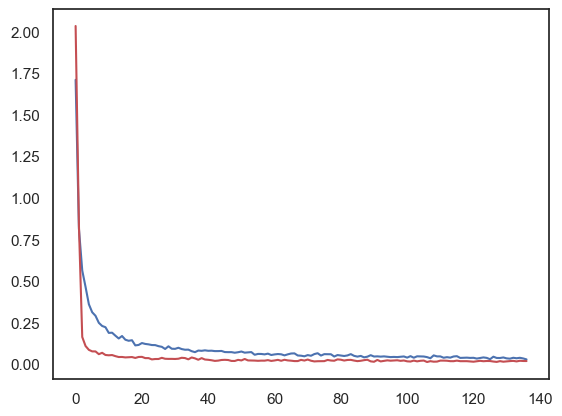

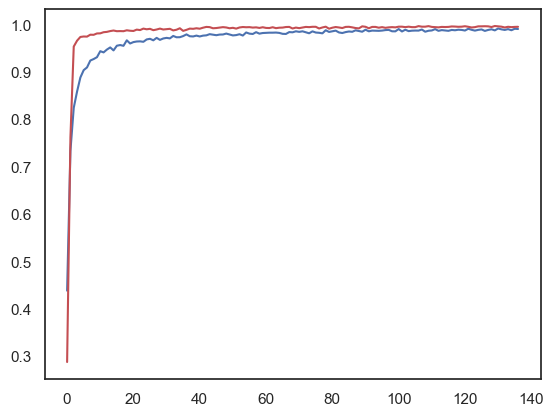

In [150]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['accuracy'], color='b')
plt.plot(hist.history['val_accuracy'], color='r')
plt.show()

In [151]:
# Prédictions et vecteur de probabilité
Y_hat = model.predict(X_val)
Y_hat[0]

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


array([1.0000000e+00, 1.4319458e-10, 1.2792675e-09, 2.2540554e-11,
       4.0215931e-11, 2.3716766e-09, 1.2000866e-08, 5.5111911e-09,
       2.2429042e-08, 5.2746563e-09], dtype=float32)

In [153]:
# Génération des vecteurs de verité (Y_true) et de prédiction (Y_pred)
Y_pred = np.argmax(Y_hat, axis=1)
Y_true = np.argmax(Y_val, axis=1)

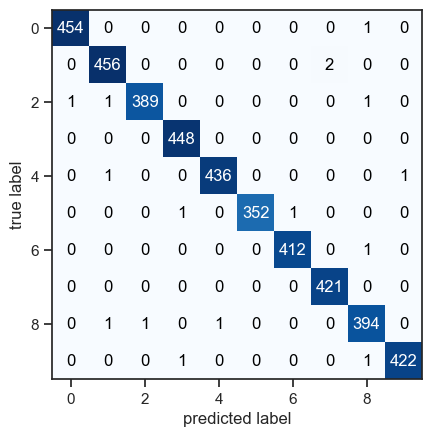

In [154]:
# Génération d'une matrice de confusion pour observer les erreurs
# Toutes les valeurs sortant de la diagonales sont les erreurs de classification

cm = confusion_matrix(Y_true, Y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [155]:
# On identifie les indices qui ont été mal classifié

diff_indices = np.where(Y_true != Y_pred)[0]
diff_indices

array([  25,   87, 1074, 1395, 2262, 2296, 2438, 2457, 2568, 2847, 3176,
       3372, 3429, 3558, 3891, 4123])

In [156]:
# On met les mauvaises classifications dans une array que l'on met aux bonnes dimensions pour affichage

X_err = X_val[diff_indices]
X_err = X_err*255
X_err = X_err.reshape(X_err.shape[0],28, 28)

Image: 0 - Indice: 25: Vérité 6, Prédiction: 8 avec proba: 0.8392741680145264
Image: 1 - Indice: 87: Vérité 9, Prédiction: 8 avec proba: 0.7405717968940735
Image: 2 - Indice: 1074: Vérité 2, Prédiction: 8 avec proba: 0.7702152132987976
Image: 3 - Indice: 1395: Vérité 0, Prédiction: 8 avec proba: 0.46280401945114136
Image: 4 - Indice: 2262: Vérité 1, Prédiction: 7 avec proba: 0.7612863779067993
Image: 5 - Indice: 2296: Vérité 5, Prédiction: 3 avec proba: 0.5071064233779907
Image: 6 - Indice: 2438: Vérité 8, Prédiction: 2 avec proba: 0.6331110596656799
Image: 7 - Indice: 2457: Vérité 9, Prédiction: 3 avec proba: 0.7400121092796326
Image: 8 - Indice: 2568: Vérité 8, Prédiction: 1 avec proba: 0.22897884249687195
Image: 9 - Indice: 2847: Vérité 2, Prédiction: 1 avec proba: 0.5083280205726624



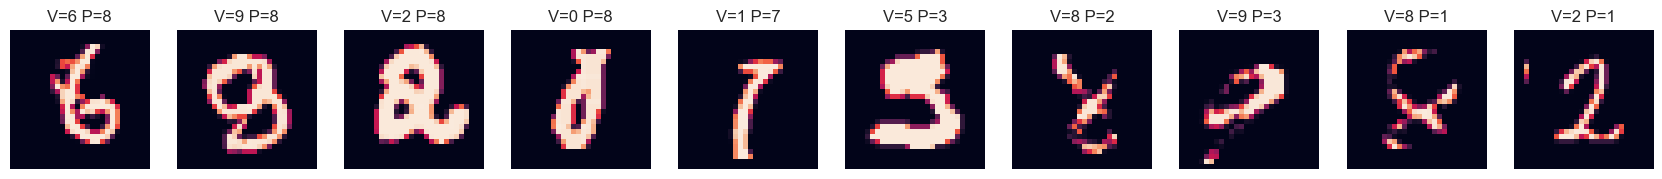

In [ ]:
# Affichage de 10 images incorrectes
plt.figure(figsize=(60, 20))
for i in range (0, 10):
    print("Image: {} - Indice: {}: Vérité {}, Prédiction: {} avec proba: {}".format(i, diff_indices[i], Y_true[diff_indices[i]], Y_pred[diff_indices[i]], Y_hat[diff_indices[i]][Y_pred[diff_indices[i]]] ))
    plt.subplot(1, 28, i + 1)
    plt.imshow(X_err[i])
    plt.title(f'V={Y_true[diff_indices[i]]} P={Y_pred[diff_indices[i]]}')
    plt.axis('off')

print("")
plt.show()

### test du modèle

In [159]:
X_test = pd.read_csv(test_dir) #lecture du fichier de test

#on fait pareil que pour les données d'entrainement
#on fait un reshape
X_test = X_test.values.reshape(-1, 28,28,1)

# normalisation
X_test = X_test / 255.0


In [160]:
Y_hat = model.predict(X_test, verbose=1)
Y_pred = np.argmax(Y_hat, axis=1)

875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step


In [161]:
# Soumission et Enregistrement des résultats
results = pd.Series(Y_pred, name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("submission.csv",index=False)

# visualisation du modèle

In [162]:
submission = pd.read_csv("submission.csv")
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


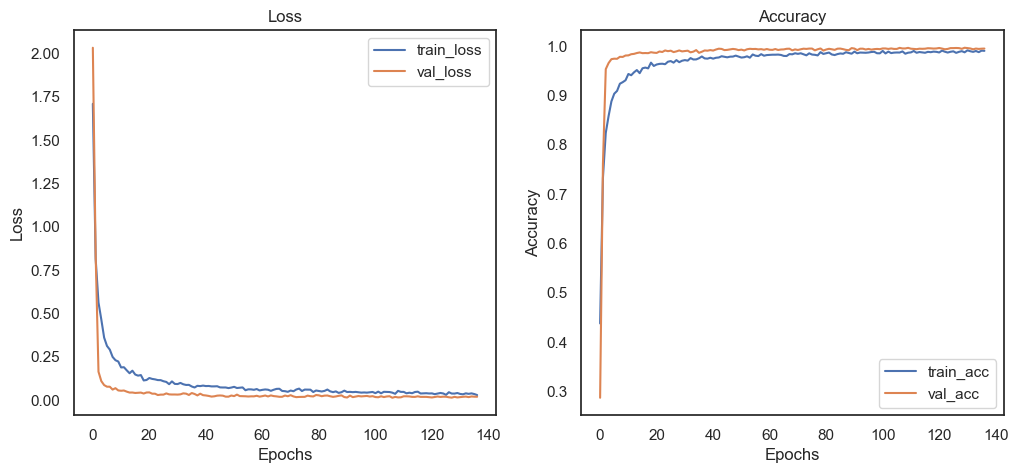

In [166]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'], label='train_acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

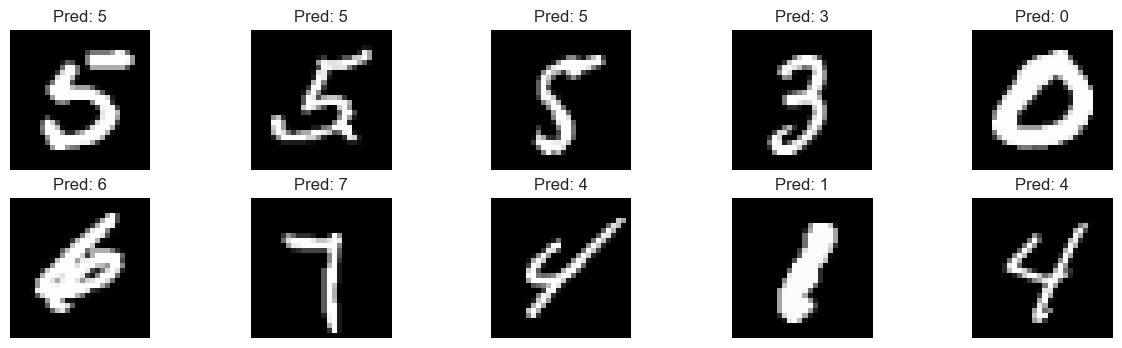

In [167]:
import numpy as np
import matplotlib.pyplot as plt

# Sélection de 10 images au hasard
indices = np.random.choice(len(X_test), 10, replace=False)

plt.figure(figsize=(15,4))
for i, idx in enumerate(indices):
    img = X_test[idx].reshape(28,28)
    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {submission['Label'][idx]}")
    plt.axis('off')
plt.show()


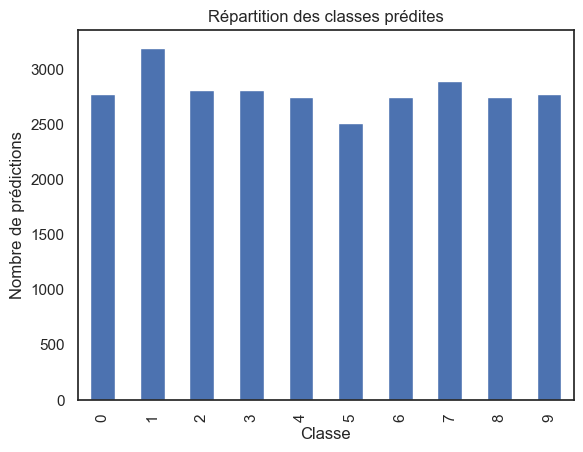

In [168]:
submission['Label'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Classe")
plt.ylabel("Nombre de prédictions")
plt.title("Répartition des classes prédites")
plt.show()


In [173]:
# Sauvegarde complète (architecture + poids + optimizer)
model.save("mon_modele_mnist.keras")

# Pour recharger plus tard
from tensorflow.keras.models import load_model
model = load_model("mon_modele_mnist.keras")

model.save_weights("poids_mnist.weights.h5")
model.load_weights("poids_mnist.weights.h5")
